# Neural Networks for SciML: Function Approximation with a Single Layer

This notebook introduces the fundamental concepts of using neural networks for function approximation, a core task in scientific machine learning (SciML). We will build up from the basic building block, the perceptron, to a single-layer network and demonstrate its capacity to approximate a simple function, connecting theory to practice using PyTorch.

## The 1D Poisson Equation: Our Benchmark Problem

We begin with a familiar problem: the one-dimensional Poisson equation on the unit interval $[0, 1]$ with homogeneous Dirichlet boundary conditions:

$$-\frac{d^2u}{dx^2} = f(x), \quad x \in [0, 1]$$

subject to boundary conditions:
$$u(0) = 0, \quad u(1) = 0$$

This equation models diverse physical phenomena: heat conduction in a rod, deflection of a loaded beam, or electrostatic potential in one dimension. The function $u(x)$ represents the unknown solution we seek, while $f(x)$ is the prescribed source term.

For our initial exploration, we choose a source term that gives a simple, known solution:
$$f(x) = \pi^2 \sin(\pi x)$$

This choice yields the analytical solution:
$$u(x) = \sin(\pi x)$$

We can verify this solution by direct substitution. The second derivative of $u(x) = \sin(\pi x)$ is $u''(x) = -\pi^2 \sin(\pi x)$, so:
$$-\frac{d^2u}{dx^2} = -(-\pi^2 \sin(\pi x)) = \pi^2 \sin(\pi x) = f(x) \quad \checkmark$$

The boundary conditions are satisfied: $u(0) = \sin(0) = 0$ and $u(1) = \sin(\pi) = 0$ ✓

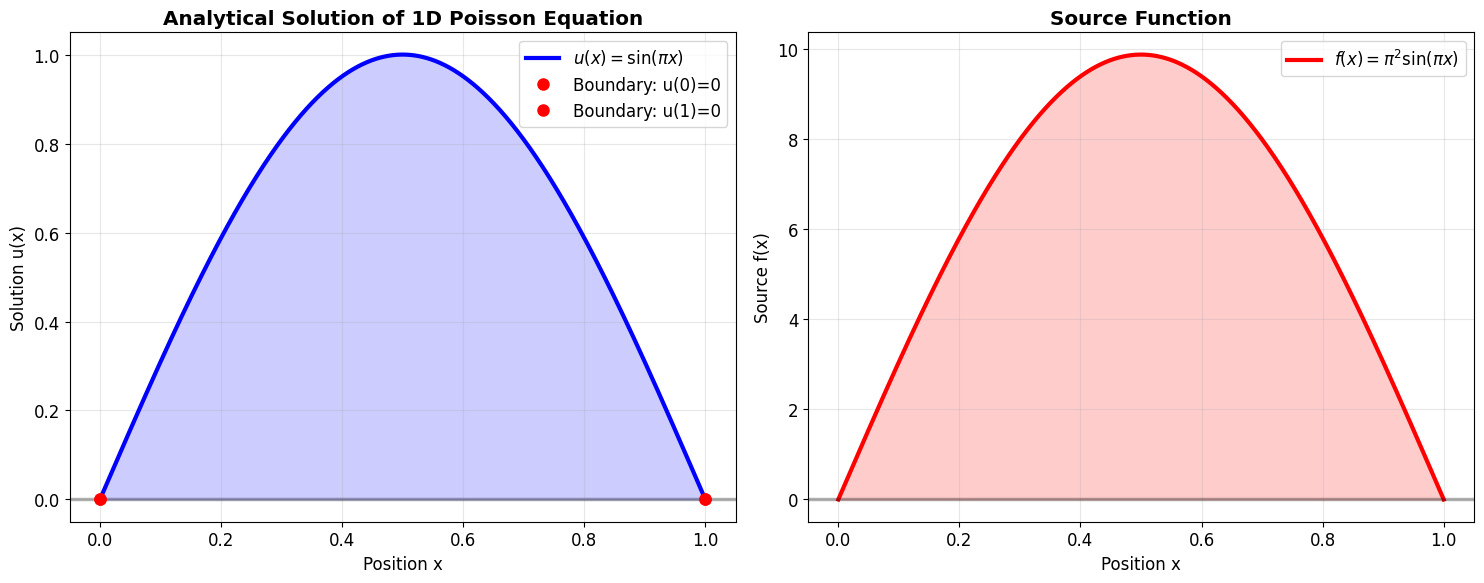

Solution satisfies boundary conditions: u(0) = 0.000000, u(1) = 0.000000


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Set up plotting style for clarity
plt.style.use('default')
plt.rcParams.update({
    'font.size': 12,
    'figure.figsize': (12, 8),
    'lines.linewidth': 2.5,
    'axes.grid': True,
    'grid.alpha': 0.3
})

# Define the domain
x_plot = np.linspace(0, 1, 1000)

# Define the analytical solution and source function
def analytical_solution(x):
    """Analytical solution: u(x) = sin(π*x)"""
    return np.sin(np.pi * x)

def source_function(x):
    """Source function: f(x) = π²*sin(π*x)"""
    return np.pi**2 * np.sin(np.pi * x)

# Compute solutions for plotting
u_analytical_plot = analytical_solution(x_plot)
f_source_plot = source_function(x_plot)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the analytical solution
ax1.plot(x_plot, u_analytical_plot, 'b-', linewidth=3, label=r'$u(x) = \sin(\pi x)$')
ax1.fill_between(x_plot, 0, u_analytical_plot, alpha=0.2, color='blue')
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax1.plot([0, 0], [0, 0], 'ro', markersize=8, label='Boundary: u(0)=0')
ax1.plot([1, 1], [0, 0], 'ro', markersize=8, label='Boundary: u(1)=0')
ax1.set_xlabel('Position x')
ax1.set_ylabel('Solution u(x)')
ax1.set_title('Analytical Solution of 1D Poisson Equation', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot the source function
ax2.plot(x_plot, f_source_plot, 'r-', linewidth=3, label=r'$f(x) = \pi^2 \sin(\pi x)$')
ax2.fill_between(x_plot, 0, f_source_plot, alpha=0.2, color='red')
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax2.set_xlabel('Position x')
ax2.set_ylabel('Source f(x)')
ax2.set_title('Source Function', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Solution satisfies boundary conditions: u(0) = {analytical_solution(0):.6f}, u(1) = {analytical_solution(1):.6f}")

## Traditional Methods vs. Neural Networks: Discrete vs. Continuous

Traditional numerical methods like the Finite Difference Method or Finite Element Method solve PDEs by **discretizing the domain** into a grid or mesh. They approximate the solution $u(x)$ by finding its values at these specific, discrete points.

For example, the Finite Difference method approximates the second derivative:
$$\frac{d^2u}{dx^2} \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2}$$
This transforms the differential equation into a system of algebraic equations for the values $u_i$ at grid points $x_i$. The result is a discrete representation of the solution.

In contrast, the Neural Network approach aims to learn a **continuous function** $u_{NN}(x; \theta)$ that approximates the true solution $u^*(x)$ over the entire domain $[0, 1]$. This function is parameterized by the network's weights and biases $\theta$. We train the network by showing it examples of the solution at sparse points $(x_i, u_i)$ and adjusting $\theta$ so the network's output $u_{NN}(x_i; \theta)$ matches $u_i$ as closely as possible.

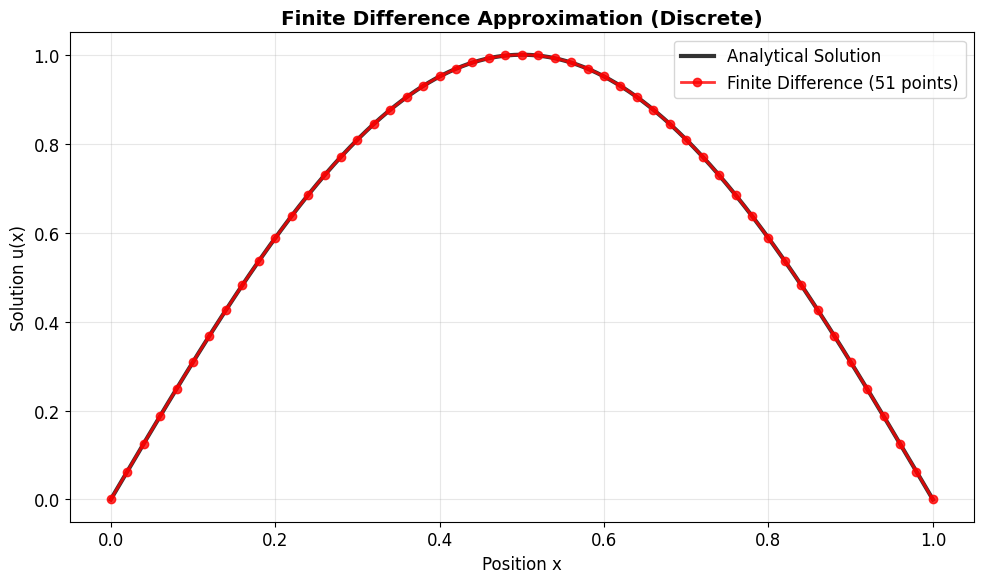

Finite Difference Max Error: 0.000329


In [4]:
# Simple finite difference solution for comparison
def solve_poisson_fd(n_points=51):
    """Solve 1D Poisson equation using finite differences"""
    # Create grid
    x_fd = np.linspace(0, 1, n_points)
    h = x_fd[1] - x_fd[0]
    
    # Create coefficient matrix A for -u'' = f
    # Central difference: u''_i ≈ (u_{i+1} - 2u_i + u_{i-1})/h²
    # Boundary conditions u_0 = u_{N-1} = 0 are handled by reducing the system size
    A = np.zeros((n_points-2, n_points-2))
    np.fill_diagonal(A, -2.0 / h**2)
    np.fill_diagonal(A[1:], 1.0 / h**2)
    np.fill_diagonal(A[:, 1:], 1.0 / h**2)
    
    # Right-hand side (source function at interior points)
    f_rhs = source_function(x_fd[1:-1])
    
    # Solve linear system A u_interior = -f_rhs
    u_interior = np.linalg.solve(A, -f_rhs)  # Note: A is for -u''
    
    # Assemble full solution (including boundary conditions)
    u_fd = np.zeros(n_points)
    u_fd[1:-1] = u_interior
    u_fd[0] = 0  # u(0) = 0
    u_fd[-1] = 0  # u(1) = 0
    
    return x_fd, u_fd

# Solve using finite differences
x_fd, u_fd = solve_poisson_fd(51) # Use 51 points for a reasonable grid

# Create comparison plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x_exact = np.linspace(0, 1, 1000)
u_exact = analytical_solution(x_exact)

ax.plot(x_exact, u_exact, 'k-', linewidth=3, label='Analytical Solution', alpha=0.8)
ax.plot(x_fd, u_fd, 'ro-', linewidth=2, markersize=6, label='Finite Difference (51 points)', alpha=0.8)

ax.set_xlabel('Position x')
ax.set_ylabel('Solution u(x)')
ax.set_title('Finite Difference Approximation (Discrete)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and print error
error_fd = np.abs(u_fd - analytical_solution(x_fd))
print(f"Finite Difference Max Error: {np.max(error_fd):.6f}")

## The Neural Network Approach: Function Approximation and Universal Approximation

Our goal is to train a neural network $u_{NN}(x; \theta)$ to approximate the continuous solution $u^*(x) = \sin(\pi x)$ over the interval $[0, 1]$. This is a **function approximation** problem.

A key theoretical result in neural networks is the **Universal Approximation Theorem**. In essence, it states:

**Theorem (Cybenko, 1989; Hornik, 1991)**: A feedforward network with a single hidden layer, containing a finite number of neurons and using a non-constant, bounded, and monotonically increasing activation function (like Sigmoid or Tanh), can approximate any continuous function on a compact domain to arbitrary accuracy.

*(Note: While the original theorem had specific activation requirements, it has been extended to other common activations like ReLU in practice).* 

The significance of this theorem is profound: it tells us that even a relatively simple network architecture (a single hidden layer) has the **theoretical capacity** to learn complex, non-linear functions like $\sin(\pi x)$, provided it has enough neurons and uses the right kind of non-linearity. We will experimentally demonstrate this capacity.

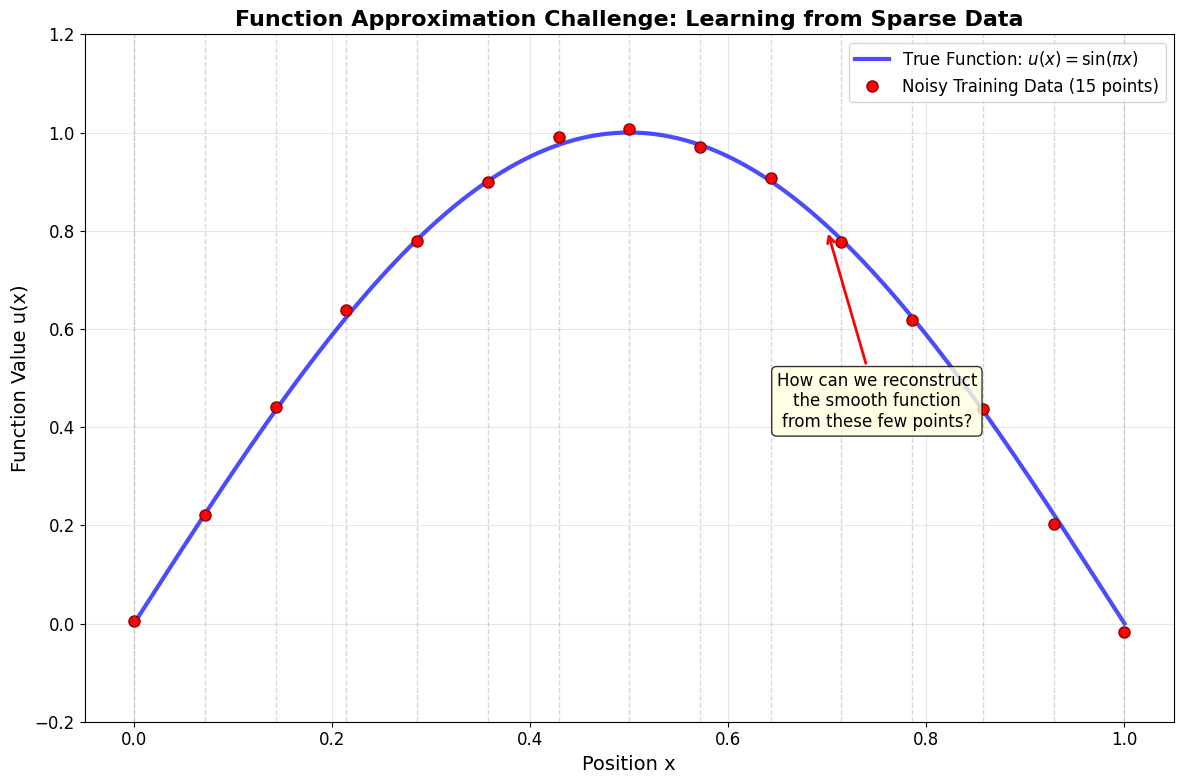

Challenge: Approximate a continuous function using only 15 data points


In [5]:
# Generate sparse training data
np.random.seed(42)  # For reproducibility
torch.manual_seed(42)

n_training_points = 15
x_train_np = np.linspace(0, 1, n_training_points)
u_train_np = analytical_solution(x_train_np)

# Add small amount of noise to make it more realistic
noise_level = 0.01
u_train_noisy_np = u_train_np + noise_level * np.random.randn(n_training_points)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train_np.reshape(-1, 1), dtype=torch.float32)
u_train_tensor = torch.tensor(u_train_noisy_np.reshape(-1, 1), dtype=torch.float32)

# Create visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the true function
x_fine = np.linspace(0, 1, 1000)
u_true_fine = analytical_solution(x_fine)
ax.plot(x_fine, u_true_fine, 'b-', linewidth=3, label='True Function: $u(x) = \sin(\pi x)$', alpha=0.7)

# Plot training data
ax.plot(x_train_np, u_train_noisy_np, 'ro', markersize=8, label=f'Noisy Training Data ({n_training_points} points)', markeredgecolor='darkred')

# Add some visual elements to emphasize the challenge
for i, xi in enumerate(x_train_np):
    ax.axvline(x=xi, color='gray', linestyle='--', alpha=0.3, linewidth=1)

ax.set_xlabel('Position x', fontsize=14)
ax.set_ylabel('Function Value u(x)', fontsize=14)
ax.set_title('Function Approximation Challenge: Learning from Sparse Data', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.2, 1.2)

# Add annotation
ax.annotate('How can we reconstruct\nthe smooth function\nfrom these few points?', 
            xy=(0.7, 0.8), xytext=(0.75, 0.4),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=12, ha='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Challenge: Approximate a continuous function using only {n_training_points} data points")

## The Basic Building Block: The Perceptron

The fundamental unit of a neural network is the **perceptron**, or artificial neuron. It takes an input vector $\boldsymbol{x}$, computes a weighted sum of its elements, adds a bias, and passes the result through an activation function $g$. 

Mathematically, for an input vector $\boldsymbol{x} = [x_1, x_2, ..., x_n]$ and corresponding weights $\boldsymbol{w} = [w_1, w_2, ..., w_n]$, with a bias $b$, the operation is:

$$z = \boldsymbol{w}^T\boldsymbol{x} + b = \sum_{i=1}^n w_i x_i + b$$

The output $\hat{y}$ is then:

$$\hat{y} = g(z)$$

Here, $z$ is the pre-activation or 'logit' value, and $g$ is the activation function.

![Perceptron](https://github.com/kks32-courses/sciml/blob/main/lectures/00-perceptron/perceptron.png?raw=true)

> Credits: Alexander Amini, MIT

## The Critical Role of Nonlinearity

Why do we need the activation function $g$? What happens if we just use a linear function, like $g(z) = z$?

Consider a network with multiple layers, but *no* non-linear activation functions between them. The output of one layer is just a linear transformation of its input. If we stack these linear layers:

Let the first layer be $h_1 = W_1 x + b_1$.
Let the second layer be $h_2 = W_2 h_1 + b_2$.

Substituting the first into the second:
$$h_2 = W_2 (W_1 x + b_1) + b_2$$
$$h_2 = W_2 W_1 x + W_2 b_1 + b_2$$

This can be rewritten as:
$$h_2 = (W_2 W_1) x + (W_2 b_1 + b_2)$$

Let $W_{eq} = W_2 W_1$ and $b_{eq} = W_2 b_1 + b_2$. Then:
$$h_2 = W_{eq} x + b_{eq}$$

This is just another linear transformation! No matter how many linear layers we stack, the entire network will only be able to compute a single linear function of the input. A linear network can only learn:

# Linear network can only learn: y = mx + b (a straight line in 1D)
# But sin(πx) is curved - impossible with just linear transformations!

To approximate complex, non-linear functions like $\sin(\pi x)$, we **must** introduce non-linearity using activation functions between the layers.

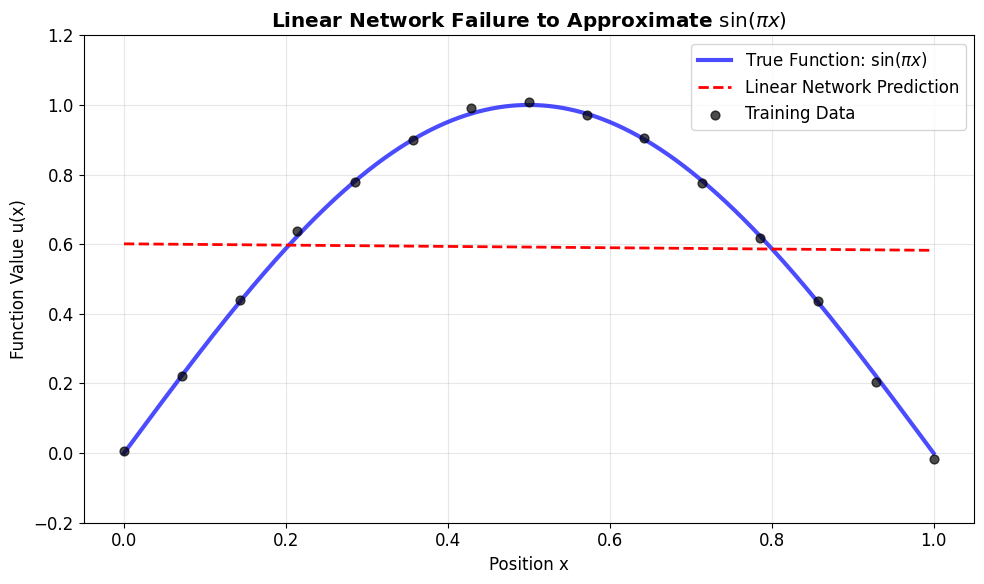

Final Loss (Linear Network): 0.119408


In [6]:
# Demonstrate Linear Network Failure

class LinearNetwork(nn.Module):
    """A simple network with only linear layers (no activation)"""
    def __init__(self, width):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, width),
            nn.Linear(width, width), # Another linear layer
            nn.Linear(width, 1)      # Final linear layer
        )
    
    def forward(self, x):
        return self.layers(x)

# Train the linear network
linear_model = LinearNetwork(width=10)
criterion = nn.MSELoss()
optimizer = optim.Adam(linear_model.parameters(), lr=0.01)

epochs = 3000
for epoch in range(epochs):
    predictions = linear_model(x_train_tensor)
    loss = criterion(predictions, u_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Visualize the linear network's prediction
x_test_tensor = torch.tensor(x_plot.reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    u_pred_linear = linear_model(x_test_tensor).numpy().flatten()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(x_plot, u_analytical_plot, 'b-', linewidth=3, label='True Function: $\sin(\pi x)$', alpha=0.7)
ax.plot(x_plot, u_pred_linear, 'r--', linewidth=2, label='Linear Network Prediction')
ax.scatter(x_train_np, u_train_noisy_np, color='k', s=40, alpha=0.7, label='Training Data', zorder=5)

ax.set_xlabel('Position x')
ax.set_ylabel('Function Value u(x)')
ax.set_title('Linear Network Failure to Approximate $\sin(\pi x)$', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.2, 1.2)

plt.tight_layout()
plt.show()

print(f"Final Loss (Linear Network): {loss.item():.6f}")

## Introducing Nonlinearity: Activation Functions

Activation functions are applied element-wise to the output of a linear transformation within a neuron or layer. They introduce the non-linearity required for neural networks to learn complex mappings.

Some common activation functions include:

**Sigmoid**
Squashes input to (0, 1). Useful for binary classification output. Can suffer from vanishing gradients.
$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

**Tanh**
Squashes input to (-1, 1). Zero-centered, often preferred over Sigmoid for hidden layers. Can also suffer from vanishing gradients.
$$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$

**ReLU (Rectified Linear Unit)**
Outputs input directly if positive, zero otherwise. Computationally efficient, helps mitigate vanishing gradients for positive inputs. Can suffer from "dead neurons" if inputs are always negative.
$$ f(x) = \max(0, x)$$

**LeakyReLU**
Similar to ReLU but allows a small gradient for negative inputs, preventing dead neurons.
$$f(x) = \max(\alpha x, x) \quad (\alpha \text{ is a small positive constant, e.g., 0.01})$$

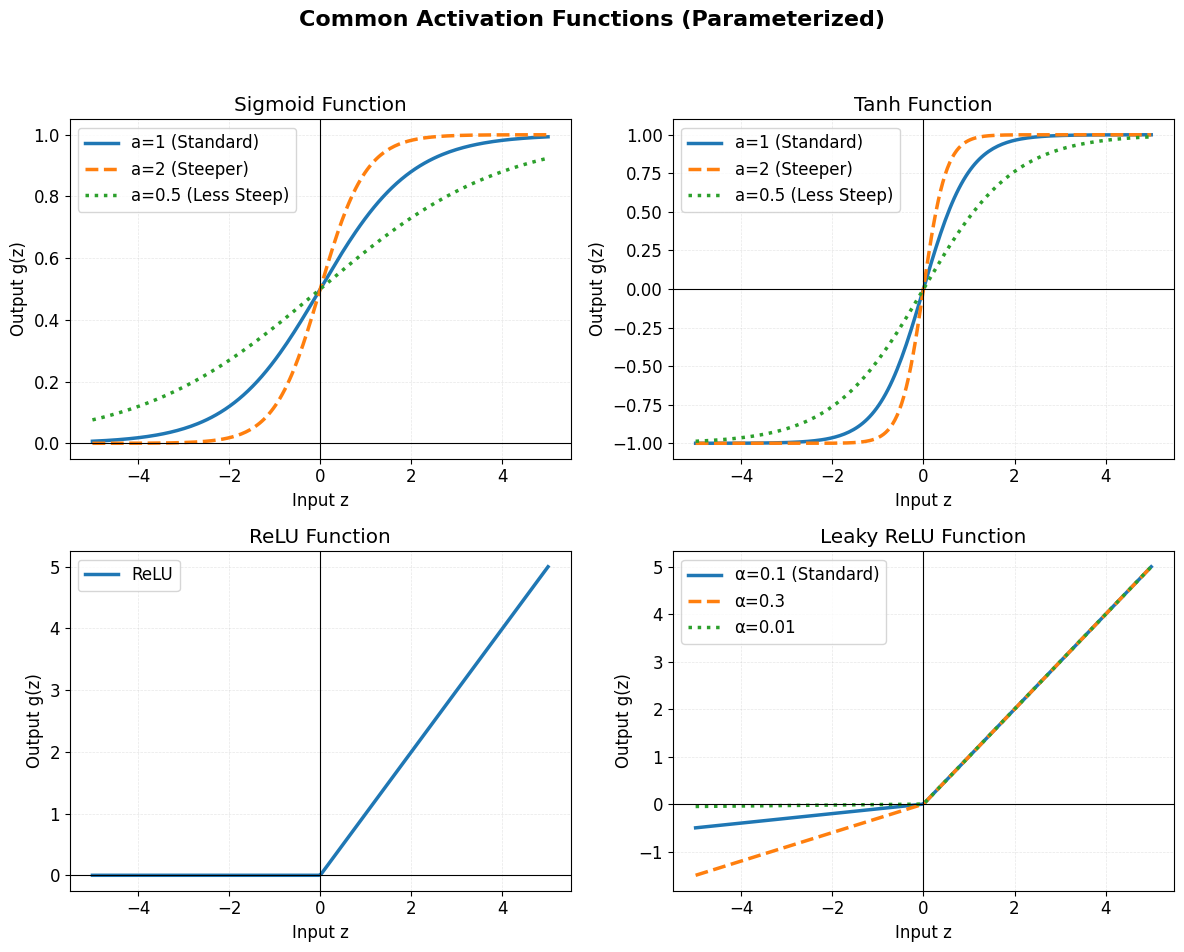

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Parameterized Activation Functions ---

def sigmoid(x, a=1.0):
    """
    Parameterized Sigmoid activation function.
    'a' controls the steepness.
    """
    return 1 / (1 + np.exp(-a * x))

def tanh(x, a=1.0):
    """
    Parameterized Hyperbolic Tangent activation function.
    'a' controls the steepness.
    """
    return np.tanh(a * x)

def relu(x):
    """
    Rectified Linear Unit (ReLU) activation function.
    It has no parameters.
    """
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.1):
    """
    Parameterized Leaky ReLU activation function.
    'alpha' is the slope for negative inputs.
    """
    return np.maximum(alpha * x, x)

# --- 2. Setup for Plotting ---

# Input data range
x = np.linspace(-5, 5, 200)

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Common Activation Functions (Parameterized)', fontsize=16, fontweight='bold')

# --- 3. Plotting each function on its subplot ---

# Sigmoid Plot (Top-Left)
axs[0, 0].plot(x, sigmoid(x, a=1), label='a=1 (Standard)')
axs[0, 0].plot(x, sigmoid(x, a=2), label='a=2 (Steeper)', linestyle='--')
axs[0, 0].plot(x, sigmoid(x, a=0.5), label='a=0.5 (Less Steep)', linestyle=':')
axs[0, 0].set_title('Sigmoid Function')
axs[0, 0].legend()

# Tanh Plot (Top-Right)
axs[0, 1].plot(x, tanh(x, a=1), label='a=1 (Standard)')
axs[0, 1].plot(x, tanh(x, a=2), label='a=2 (Steeper)', linestyle='--')
axs[0, 1].plot(x, tanh(x, a=0.5), label='a=0.5 (Less Steep)', linestyle=':')
axs[0, 1].set_title('Tanh Function')
axs[0, 1].legend()

# ReLU Plot (Bottom-Left)
axs[1, 0].plot(x, relu(x), label='ReLU')
axs[1, 0].set_title('ReLU Function')
axs[1, 0].legend()

# Leaky ReLU Plot (Bottom-Right)
axs[1, 1].plot(x, leaky_relu(x, alpha=0.1), label='α=0.1 (Standard)')
axs[1, 1].plot(x, leaky_relu(x, alpha=0.3), label='α=0.3', linestyle='--')
axs[1, 1].plot(x, leaky_relu(x, alpha=0.01), label='α=0.01', linestyle=':')
axs[1, 1].set_title('Leaky ReLU Function')
axs[1, 1].legend()

# --- 4. Final Touches for all subplots ---

# Apply common labels, grids, and axis lines to all subplots
for ax in axs.flat:
    ax.set_xlabel('Input z')
    ax.set_ylabel('Output g(z)')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.axhline(y=0, color='k', linewidth=0.8)
    ax.axvline(x=0, color='k', linewidth=0.8)

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()


## Interactive Demo: Visualizing Nonlinear Transformation

This interactive demo illustrates how a combination of linear transformation and non-linearity can transform data in a way that linear transformations alone cannot. Observe how the data, initially not linearly separable in the input space (X), becomes separable after passing through a linear layer (Y) and then a non-linear activation (Z).

This provides intuition for why layers with non-linear activations are powerful: they can map data into a new space where complex patterns become simpler (potentially linearly separable), making them learnable by subsequent layers.

## Building Capacity: The Single-Layer Network (MLP)

A single perceptron is limited in the complexity of functions it can represent. To increase capacity, we combine multiple perceptrons into a **layer**. A single-layer feedforward neural network (also known as a shallow Multi-Layer Perceptron or MLP) consists of an input layer, one hidden layer of neurons, and an output layer.

For our 1D input $x$, a single-layer network with $N_h$ hidden neurons works as follows:

1.  **Input Layer**: Receives the input $x$.
2.  **Hidden Layer**: Each of the $N_h$ neurons in this layer performs a linear transformation on the input $x$ and applies a non-linear activation function $g$. The output of this layer is a vector $\boldsymbol{h}$ of size $N_h$.
    *   Pre-activation vector $\boldsymbol{z}^{(1)}$ (size $N_h$): $\boldsymbol{z}^{(1)} = W^{(1)}\boldsymbol{x} + \boldsymbol{b}^{(1)}$
        (Here, $W^{(1)}$ is a $N_h \times 1$ weight matrix, $\boldsymbol{x}$ is treated as a $1 \times 1$ vector, and $\boldsymbol{b}^{(1)}$ is a $N_h \times 1$ bias vector).
    *   Activation vector $\boldsymbol{h}$ (size $N_h$): $\boldsymbol{h} = g(\boldsymbol{z}^{(1)})$ (where $g$ is applied element-wise).
3.  **Output Layer**: This layer takes the vector $\boldsymbol{h}$ from the hidden layer and performs another linear transformation to produce the final scalar output $\hat{y}$. For regression, the output layer typically has a linear activation (or no activation function explicitly applied after the linear transformation).
    *   Pre-activation scalar $z^{(2)}$: $z^{(2)} = W^{(2)}\boldsymbol{h} + b^{(2)}$
        (Here, $W^{(2)}$ is a $1 \\times N_h$ weight matrix, and $b^{(2)}$ is a scalar bias).
    *   Final output $\hat{y}$: $\hat{y} = z^{(2)}$

![Single layer NN](https://github.com/kks32-courses/sciml/blob/main/lectures/00-perceptron/single-layer-nn2.png?raw=true)

> Credits: Alexander Amini, MIT

In [8]:
# Implement Single-Layer NN in PyTorch

class SingleLayerNN(nn.Module):
    """Single hidden layer neural network for 1D input/output"""
    
    def __init__(self, hidden_size=10, activation='tanh'):
        super(SingleLayerNN, self).__init__()
        
        # Input layer (1D) to Hidden layer (hidden_size)
        self.hidden = nn.Linear(1, hidden_size)
        
        # Hidden layer (hidden_size) to Output layer (1D)
        self.output = nn.Linear(hidden_size, 1)
        
        # Choose activation function for the hidden layer
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        else:
            # Default to Tanh or raise error, linear is handled by no activation
            raise ValueError("Unsupported activation function")
    
    def forward(self, x):
        # Pass through hidden layer and apply activation
        x = self.hidden(x)
        x = self.activation(x)
        
        # Pass through output layer (linear output)
        x = self.output(x)
        return x

## Training the Network: Optimization

The goal of training is to find the optimal set of weights and biases $\theta^*$ for the network that minimize the difference between the network's output $u_{NN}(x; \theta)$ and the true training data $u_{train}$.

We quantify this difference using a **Loss Function**. For our function approximation (regression) task, the Mean Squared Error (MSE) is a common choice:

$$\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^N \left(u_{NN}(x_i; \theta) - u_i\right)^2$$

Minimizing this loss function with respect to the parameters $\theta$ is an optimization problem.

## Optimization Algorithm: Gradient Descent

**Gradient Descent** is the core algorithm used to find the minimum of the loss function. It works by iteratively adjusting the parameters $\theta$ in the direction opposite to the gradient of the loss function $\nabla \mathcal{L}(\theta)$. The gradient points in the direction of the steepest increase in the loss, so moving in the opposite direction decreases the loss.

The update rule for the parameters $\theta$ is:

$$\theta \leftarrow \theta - \eta \nabla \mathcal{L}(\theta)$$

Here, $\eta$ is the **learning rate**, a hyperparameter that controls the step size of the updates.

The training process involves these steps, repeated over many **epochs** (full passes through the training data):

1.  **Forward Pass:** Feed the training data through the network to compute predictions $u_{NN}(x_i; \theta)$.
2.  **Calculate Loss:** Compute the loss $\mathcal{L}(	heta)$ using the predictions and the true training data.
3.  **Backward Pass (Backpropagation):** Compute the gradients of the loss with respect to all parameters $\nabla \mathcal{L}(\theta)$. PyTorch handles this automatically using backpropagation.
4.  **Optimizer Step:** Update the parameters $\theta$ using the gradients and the learning rate (e.g., using the Gradient Descent update rule or a more advanced optimizer like Adam).
5.  **Repeat:** Go to the next epoch.

![SGD](https://github.com/kks32-courses/sciml/blob/main/lectures/00-perceptron/sgd.gif?raw=true)

In [9]:
# Implement PyTorch Training Loop Function

def train_network(model, x_train, u_train, epochs=5000, lr=0.01):
    """Train a neural network model using MSE loss and Adam optimizer"""
    criterion = nn.MSELoss() # Mean Squared Error Loss
    optimizer = optim.Adam(model.parameters(), lr=lr) # Adam optimizer
    
    losses = []
    
    for epoch in range(epochs):
        # Forward pass: compute predictions
        predictions = model(x_train)
        
        # Calculate loss
        loss = criterion(predictions, u_train)
        
        # Backward pass: compute gradients
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Compute gradients of the loss w.r.t. parameters
        
        # Optimizer step: update parameters
        optimizer.step()      # Perform a single optimization step
        
        losses.append(loss.item())
        
        # Optional: Print loss periodically
        # if (epoch + 1) % 1000 == 0:
        #     print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
    
    return losses

In [10]:
# Train Single-Layer NNs with Varying Width (The Experiment)

# Define hidden layer sizes to experiment with
hidden_sizes = [5, 10, 20, 50]

# Choose an activation function for the hidden layer
activation_fn = 'tanh' # Tanh often works well for smooth functions

# Dictionaries to store trained models and their loss histories
single_layer_models = {}
single_layer_losses = {}

epochs = 8000 # Number of training epochs
lr = 0.01     # Learning rate

print(f"Training single-layer networks with {activation_fn} activation...")

# Loop through different hidden sizes and train a model for each
for hidden_size in hidden_sizes:
    print(f"\nTraining network with {hidden_size} neurons...")
    
    # Instantiate the model
    model = SingleLayerNN(hidden_size=hidden_size, activation=activation_fn)
    
    # Train the model
    losses = train_network(model, x_train_tensor, u_train_tensor, epochs=epochs, lr=lr)
    
    # Store the trained model and loss history
    single_layer_models[hidden_size] = model
    single_layer_losses[hidden_size] = losses
    
    print(f"Final loss for {hidden_size} neurons: {losses[-1]:.6f}")

print("\nTraining complete.")

Training single-layer networks with tanh activation...

Training network with 5 neurons...
Final loss for 5 neurons: 0.000044

Training network with 10 neurons...
Final loss for 10 neurons: 0.000046

Training network with 20 neurons...
Final loss for 20 neurons: 0.000044

Training network with 50 neurons...
Final loss for 50 neurons: 0.000041

Training complete.


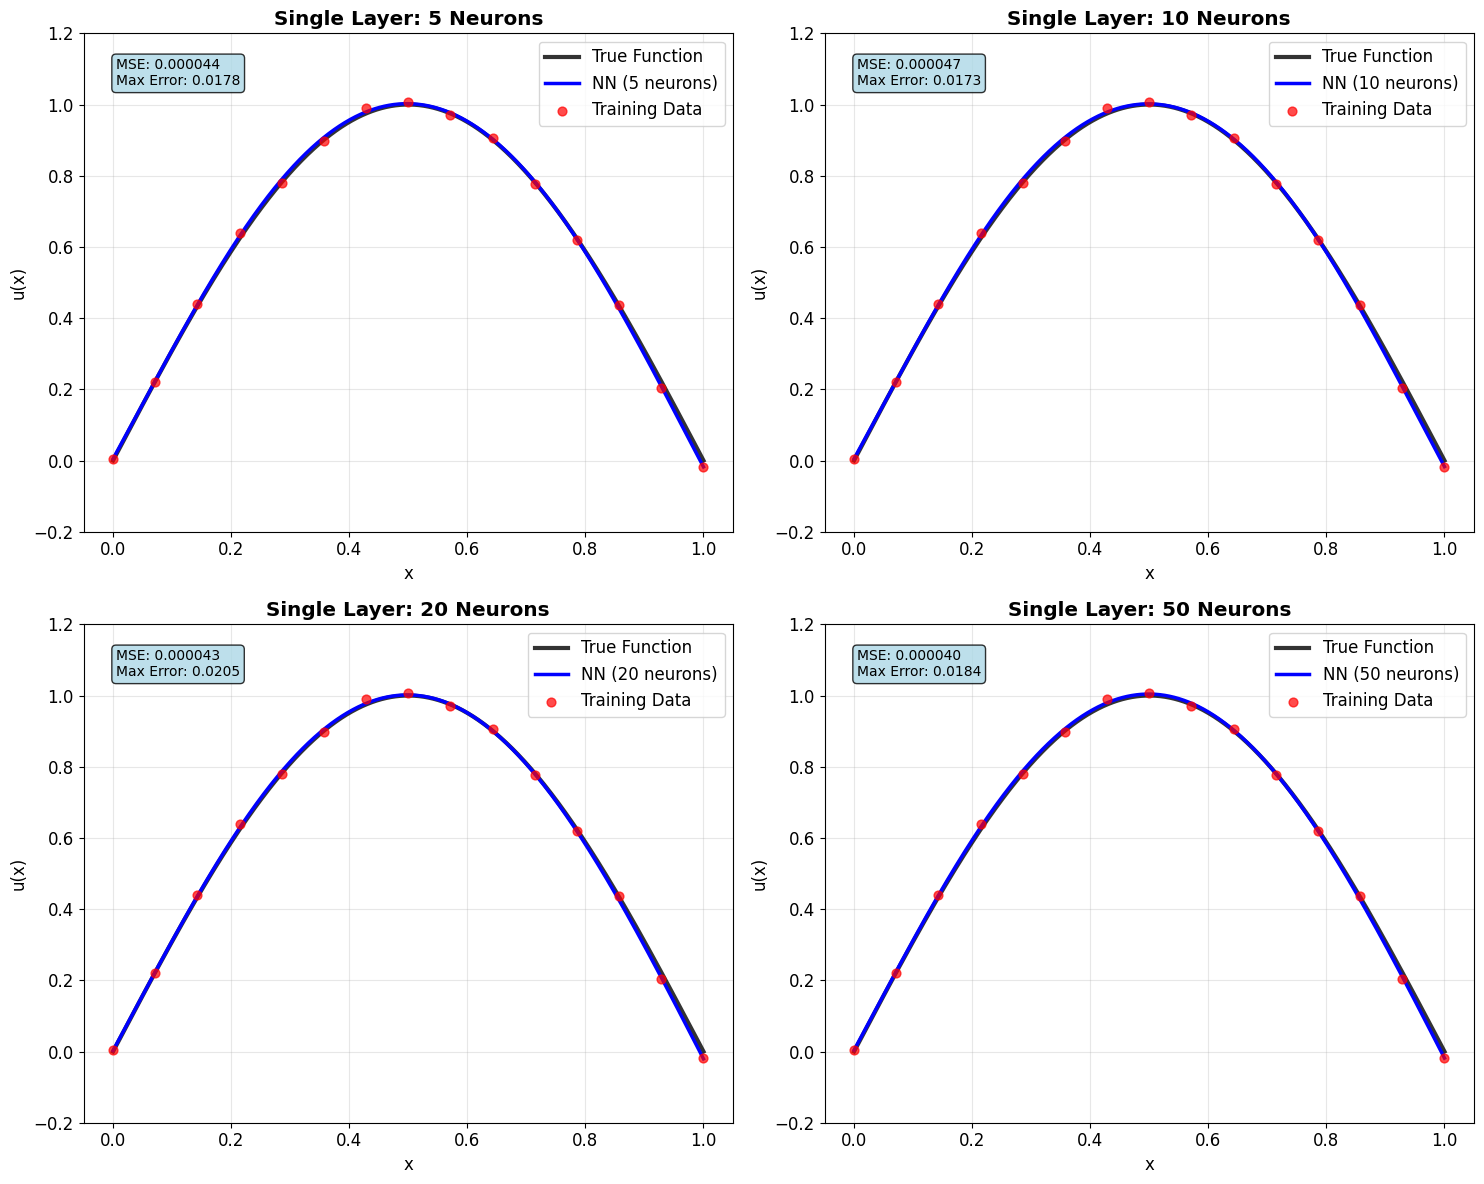

In [11]:
# Visualize Results: Approximation Quality vs. Width

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

x_test_tensor = torch.tensor(x_plot.reshape(-1, 1), dtype=torch.float32)

for i, hidden_size in enumerate(hidden_sizes):
    ax = axes[i]
    model = single_layer_models[hidden_size]
    
    # Get predictions from the trained model
    with torch.no_grad(): # Disable gradient calculation for inference
        u_pred = model(x_test_tensor).numpy().flatten()
    
    # Plot true function
    ax.plot(x_plot, u_analytical_plot, 'k-', linewidth=3, label='True Function', alpha=0.8)
    
    # Plot NN prediction
    ax.plot(x_plot, u_pred, 'b-', linewidth=2.5, 
            label=f'NN ({hidden_size} neurons)')
    
    # Plot training data
    ax.scatter(x_train_np, u_train_noisy_np, color='red', s=40, alpha=0.7, 
              label='Training Data', zorder=5)
    
    # Calculate and display error metrics
    mse = np.mean((u_pred - u_analytical_plot)**2)
    max_error = np.max(np.abs(u_pred - u_analytical_plot))
    
    ax.text(0.05, 0.95, f'MSE: {mse:.6f}\nMax Error: {max_error:.4f}', 
            transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
            verticalalignment='top', fontsize=10)
    
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
    ax.set_title(f'Single Layer: {hidden_size} Neurons', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.2, 1.2)

plt.tight_layout()
plt.show()

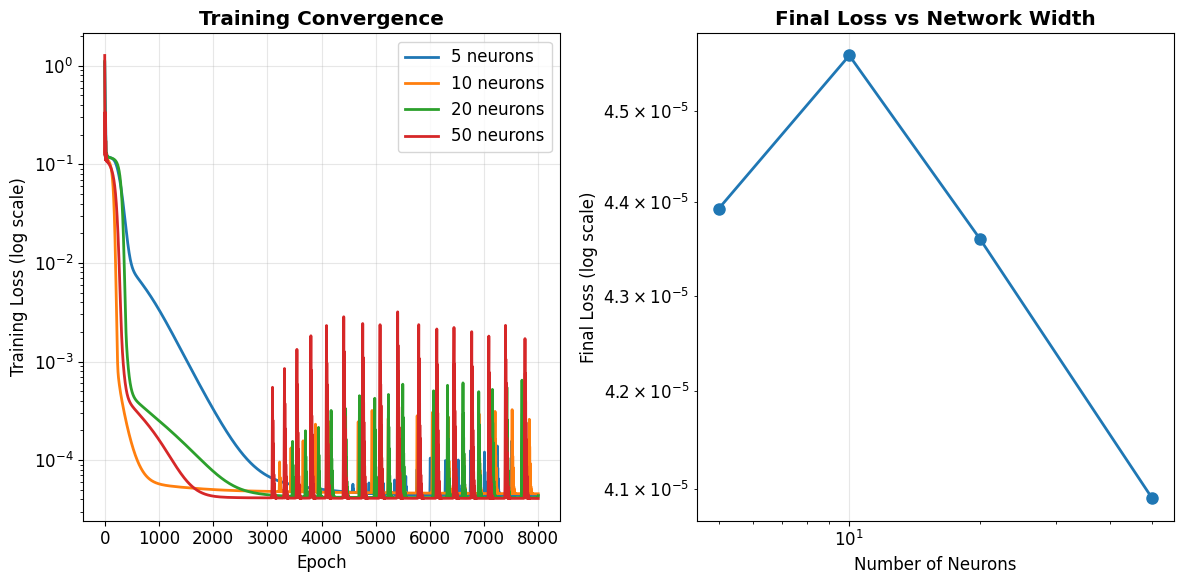


Final Loss Summary:
 5 neurons: 0.00004393
10 neurons: 0.00004562
20 neurons: 0.00004361
50 neurons: 0.00004090


In [12]:
# Visualize Results: Training Convergence vs. Width

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for hidden_size in hidden_sizes:
    losses = single_layer_losses[hidden_size]
    plt.semilogy(losses, label=f'{hidden_size} neurons', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Training Loss (log scale)')
plt.title('Training Convergence', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
final_losses = [single_layer_losses[h][-1] for h in hidden_sizes]
plt.loglog(hidden_sizes, final_losses, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Neurons')
plt.ylabel('Final Loss (log scale)')
plt.title('Final Loss vs Network Width', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal Loss Summary:")
for hidden_size in hidden_sizes:
    loss = single_layer_losses[hidden_size][-1]
    print(f"{hidden_size:2d} neurons: {loss:.8f}")

## Analysis: Universal Approximation, Width, and Practicalities

The visualizations from our experiment (Cells 18 & 19) show a clear trend: as we increased the number of neurons in the hidden layer (the network's **width**), the network's ability to approximate the $\sin(\pi x)$ function significantly improved, and the final training loss decreased.

This experimental result **experimentally validates** the statement of the **Universal Approximation Theorem** (from Cell 5) – a single hidden layer with non-linearity *does* have the capacity to approximate continuous functions, and increasing the number of neurons provides more of this capacity, allowing it to better fit the target function.

However, the theorem guarantees existence, not practicality. Our experiment also hints at practical considerations:

*   **Number of Neurons Needed**: While 50 neurons did a good job for $\sin(\pi x)$, approximating more complex functions might require a very large number of neurons in a single layer. This can be computationally expensive and require a lot of data.
*   **Training Difficulty**: The theorem doesn't guarantee that gradient descent will successfully *find* the optimal parameters. Training can be challenging, especially for very wide networks or complex functions.
*   **Remaining Errors**: Even with 50 neurons, there's still some error. For more complex functions or higher accuracy requirements, a single layer might struggle or need excessive width.

### Practical Considerations: Overfitting and Hyperparameters

As network capacity increases (e.g., by adding more neurons), there's a risk of **overfitting**. This occurs when the model learns the training data (including noise) too well, capturing spurious patterns that don't generalize to unseen data, leading to poor performance outside the training set.

![overfitting](https://github.com/kks32-courses/sciml/blob/main/lectures/00-perceptron/overfitting.png?raw=true)

> Example of under and overfitting the data

Overfitting can be detected by monitoring performance on a separate **validation set** during training. If the validation loss starts increasing while the training loss continues to decrease, it's a sign of overfitting.

Strategies to mitigate overfitting include using more training data, regularization techniques, early stopping (stopping training when validation performance degrades), or reducing model complexity.

**Hyperparameters** are settings chosen *before* training that significantly influence the learning process and the final model. Key hyperparameters we've encountered include:

*   **Learning Rate** ($\eta$): Controls the step size in gradient descent. Too high can cause divergence; too low can lead to slow convergence or getting stuck in local minima.
*   **Number of Epochs**: How many times the training data is passed through the network. Too few may result in underfitting; too many can cause overfitting.
*   **Hidden Layer Size** ($N_h$): The number of neurons in the hidden layer. Impacts model capacity. Too small can underfit; too large can overfit.
*   **Choice of Activation Function**: Impacts the network's ability to model specific shapes and the training dynamics (e.g., Tanh/Sigmoid for smooth functions but potential vanishing gradients, ReLU for efficiency but "dead neuron" issue). The best choice can be problem-dependent.

Finding the right balance of hyperparameters is crucial for successful training and generalization.

## Summary and What's Next

In this notebook, we've covered foundational concepts for using neural networks in SciML function approximation:

*   We framed the 1D Poisson problem as a function approximation task, contrasting it with traditional discrete methods.
*   We introduced the Perceptron as the basic building block.
*   We established the critical need for **Nonlinearity** using activation functions, demonstrating the failure of purely linear networks and visualizing transformations.
*   We built and implemented a **Single-Layer Network (MLP)** in PyTorch.
*   We introduced the training process using **Loss Functions** (MSE) and **Gradient Descent**.
*   We experimentally demonstrated the network's capacity by showing improved approximation quality with increasing **Width**, connecting this to the **Universal Approximation Theorem**.
*   We discussed practical challenges like **Overfitting** and the importance of **Hyperparameters**.

**Key Takeaway**: Single-layer networks with non-linear activations have the theoretical capacity to approximate continuous functions and can work well for relatively simple ones like $\sin(\pi x)$, with approximation improving with width. However, practical limitations exist regarding the number of neurons needed and training efficiency, especially for more complex problems.

This leads us to the next question: How do we efficiently approximate more complex functions or improve learning for challenging problems without relying solely on making a single layer extremely wide? This motivates the idea of **Deep Learning** – using multiple hidden layers.

Our subsequent notebooks will explore the advantages and necessity of deep neural networks.